<a href="https://colab.research.google.com/github/Nawa-Punabantu/Opt_Algos/blob/main/ParEGO_EI_5d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from scipy.stats import norm




In [36]:

# --- Define 5D objective functions ---

def objective_f1(x):
    x1, x2, x3, x4, x5 = x
    return (
        np.sin(x1) * np.cos(x2)
        + 0.1 * (x3 - 3)**2
        + np.exp(-((x4 - 1)**2 + (x5 + 2)**2))
        + np.sin(x1 * x5)
    )

def objective_f2(x):
    x1, x2, x3, x4, x5 = x
    return (
        np.log1p(x1**2 + x2**2)
        + np.abs(x3 * x4 - x5)
        + np.cos(x1 + x2 + x3)
        + 0.5 * (x5 - 1)**2
    )



# --- Surrogate model creation ---
def surrogate_model(X_train, y_train):
    kernel = C(1.0, (1e-4, 10.0)) * RBF(1.0, (1e-4, 10.0))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, normalize_y=True, n_restarts_optimizer=5)
    gp.fit(X_train, y_train)
    return gp

# --- Scalarized surrogate objective for ParEGO ---

def scalarized_surrogate_objective(x, surrogate_f1, surrogate_f2, weights):
    """
    outputs a scalar given the scalar fromed from the inputs
    the candidated point [x] is evaluated at the surrogate_f1 & surrogate_f2

    and the value of the Tchebycheb at x is then evaluated

    this is the form expected by the, differential_evolution function since
    we are directly optimizaing the Tchebychev function and not the EI

    """

    f1_pred = surrogate_f1.predict([x])[0]
    f2_pred = surrogate_f2.predict([x])[0]

    # Tchebycheff scalarization
    scalar_value = max(weights[0] * f1_pred, weights[1] * f2_pred)

    # Add nonlinear augmentation (optional, per ParEGO paper)
    phi = 0.05
    scalar_value += phi * (weights[0] * f1_pred + weights[1] * f2_pred)

    return scalar_value

# --- AQ func: Expected Improvement ---
def expected_improvement(x, surrogate_f1, surrogate_f2, weights, y_best):
    """
    Computes the Expected Improvement at a point x.
    Scalarizes the surrogate predictions using Tchebycheff, then computes EI.
    """
    x = np.array(x).reshape(1, -1)

    mu_f1, sigma_f1 = surrogate_f1.predict(x, return_std=True)
    mu_f2, sigma_f2 = surrogate_f2.predict(x, return_std=True)

    mu_scalar = np.maximum(weights[0] * mu_f1, weights[1] * mu_f2)
    phi = 0.05
    mu_scalar += phi * (weights[0] * mu_f1 + weights[1] * mu_f2)

    # Approximate variance of scalarized objective
    sigma_scalar = np.sqrt(weights[0]**2 * sigma_f1**2 + weights[1]**2 * sigma_f2**2)

    # Compute EI
    with np.errstate(divide='warn'):
        Z = (y_best - mu_scalar) / sigma_scalar
        ei = (y_best - mu_scalar) * norm.cdf(Z) + sigma_scalar * norm.pdf(Z)
        ei[sigma_scalar == 0.0] = 0.0

    return -ei[0]  # Negative for minimization


# --- Initialize random population ---
def initialize_population(pop_size, bounds):
    """
    outputs a matrix of mxn, where:
    m => number of (random) samples
    n => sampled values of the nth variable, we have 2 vars here so; mx2.

    This is where we would place a latin hypercube routine
    to select initial points

    Note that each row, correspondes to 1 scalar point for each objective


    """
    return np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))

# --- Update Pareto front ---
def update_pareto_front(pop, f1_vals, f2_vals):
    pareto = []
    for i in range(len(pop)):
        dominated = False
        for j in range(len(pop)):
            if (f1_vals[j] <= f1_vals[i] and f2_vals[j] <= f2_vals[i]) and (f1_vals[j] < f1_vals[i] or f2_vals[j] < f2_vals[i]):
                dominated = True
                break
        if not dominated:
            pareto.append([f1_vals[i], f2_vals[i]])
    return np.array(pareto)

# --- ParEGO Main Loop ---
def par_ego(num_generations, pop_size, bounds):
    population = initialize_population(pop_size, bounds)

    f1_vals = np.array([objective_f1(p) for p in population])
    f2_vals = np.array([objective_f2(p) for p in population])
    # Note that: objective_f1(p) for p in population loops through each row
    # Each row is a sample. If we have m rows, the length of f1_vals and
    # f2_vals, is m.

    # Initialize where we will store solutions
    pareto_all = []

    for gen in range(num_generations):
        # generation = iteration

        # Train surrogate models
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces
        surrogate_f1 = surrogate_model(population, f1_vals)
        surrogate_f2 = surrogate_model(population, f2_vals)
        # Note that for 2d x vals, surrogate_f1 and surrogate_f2
        # are 3d surfaces

        # Generate random weights for scalarization
        lam = np.random.rand()
        weights = [lam, 1 - lam]
        # Note that we generate new weights in each iteration/generation
        # i.e. each time we update the training set

        # Scalarized function value of current best point
        phi = 0.05
        f1_preds = surrogate_f1.predict(population)
        f2_preds = surrogate_f2.predict(population)
        scalar_preds = np.maximum(weights[0] * f1_preds, weights[1] * f2_preds)
        scalar_preds += phi * (weights[0] * f1_preds + weights[1] * f2_preds)
        y_best = np.min(scalar_preds)

        # Optimize EI instead of Tchebycheff directly
        result = differential_evolution(
            expected_improvement,
            bounds=bounds,
            args=(surrogate_f1, surrogate_f2, weights, y_best),
            maxiter=20,
            popsize=10,
            seed=42,
            disp=False
        )

        x_new = result.x
        f1_new = objective_f1(x_new)
        f2_new = objective_f2(x_new)

        # Add to population
        population = np.vstack((population, x_new))
        f1_vals = np.append(f1_vals, f1_new)
        f2_vals = np.append(f2_vals, f2_new)

        # Store current pareto
        pareto = update_pareto_front(population, f1_vals, f2_vals)
        pareto_all.append(pareto)

        print(f"Gen {gen+1} | New f1: {f1_new:.4f}, f2: {f2_new:.4f}")

    return pareto_all[-1], f1_vals, f2_vals



In [ ]:
# Define bounds for each dimension (5D)
bounds = np.array([
    [-5, 5],  # x1
    [-5, 5],  # x2
    [-5, 5],  # x3
    [-5, 5],  # x4
    [-5, 5],  # x5
])
num_generations = 50
pop_size = 5
population = np.random.uniform(bounds[:, 0], bounds[:, 1], (pop_size, bounds.shape[0]))
for p in population:
  print(p)

[ 4.65729529  3.88146843  2.99553725 -2.2837744   2.23277708]
[-3.74081941 -0.99329628  3.23482399  1.64321467  2.43580141]
[-1.13409389  1.73419641  4.62133927  2.66594369 -3.99053655]
[-2.39418142  2.9112585  -3.27137878 -0.73326935 -2.93143592]
[ 2.85472635 -0.21397283  2.08164913 -1.18019882 -4.7150795 ]


In [ ]:
# --- Run ParEGO ---
bounds = np.array([
    [-5, 5],  # x1
    [-5, 5],  # x2
    [-5, 5],  # x3
    [-5, 5],  # x4
    [-5, 5],  # x5
])
num_generations = 100 # C iterations
pop_size = 20     # number of initial samples to draw and train the GPs on.

pareto_front, all_f1, all_f2 = par_ego(num_generations, pop_size, bounds)



Gen 1 | New f1: 1.0754, f2: 1.6117
Gen 2 | New f1: 0.8762, f2: 4.0797
Gen 3 | New f1: 2.1204, f2: 2.6713
Gen 4 | New f1: 3.2474, f2: 6.6876
Gen 5 | New f1: -0.0417, f2: 4.0502
Gen 6 | New f1: 0.3973, f2: 2.2440
Gen 7 | New f1: 0.1929, f2: 5.2875
Gen 8 | New f1: 5.7423, f2: 8.7012
Gen 9 | New f1: 4.7149, f2: 16.0180
Gen 10 | New f1: 5.8846, f2: 11.9386
Gen 11 | New f1: -0.2323, f2: 10.1718
Gen 12 | New f1: 0.8374, f2: 1.8663
Gen 13 | New f1: 0.1762, f2: 2.5385
Gen 14 | New f1: 1.8898, f2: 3.2906
Gen 15 | New f1: 0.8618, f2: 2.1909
Gen 16 | New f1: 0.5311, f2: 4.0820
Gen 17 | New f1: 1.1295, f2: 4.7132
Gen 18 | New f1: -0.4274, f2: 4.5725
Gen 19 | New f1: -0.8058, f2: 15.5197
Gen 20 | New f1: -0.4047, f2: 6.6622
Gen 21 | New f1: -0.4842, f2: 3.2419
Gen 22 | New f1: -0.3081, f2: 14.8293
Gen 23 | New f1: -0.1827, f2: 18.3620
Gen 24 | New f1: 1.9026, f2: 19.7713
Gen 25 | New f1: 0.8339, f2: 10.7787
Gen 26 | New f1: -0.4741, f2: 1.5667
Gen 27 | New f1: 0.2162, f2: 8.4763
Gen 28 | New f1: -0.

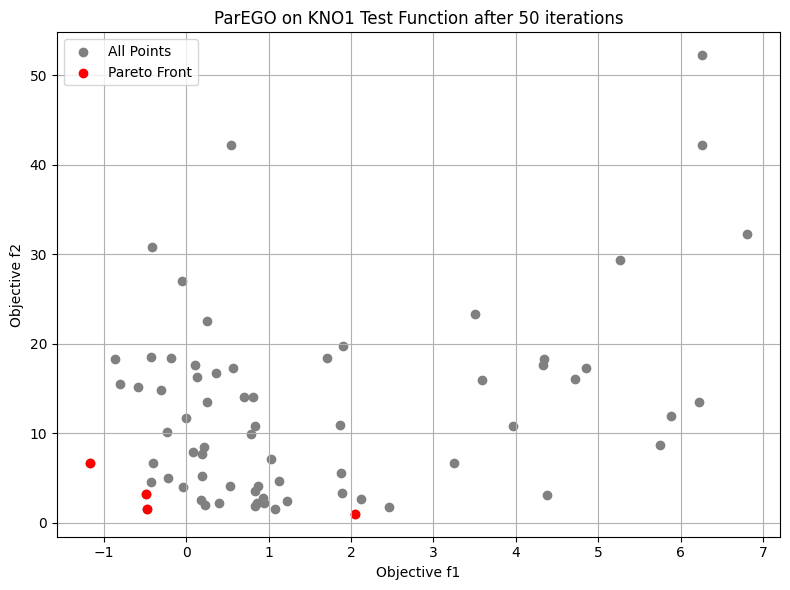

In [35]:
# --- Plot Results ---
plt.figure(figsize=(8, 6))
plt.scatter(all_f1, all_f2, c='gray', label="All Points")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', label="Pareto Front")
plt.xlabel("Objective f1")
plt.ylabel("Objective f2")
plt.title(f"ParEGO on KNO1 Test Function after {num_generations} iterations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()